In [1]:
# using CuArrays # comment me out if you don't want to use GPU
using Flux, Flows
import MLToolkit; const MLT = MLToolkit; const plt = MLT.plt
using Tracker: update!

## Generate some data from a mixture of two Gaussians to use

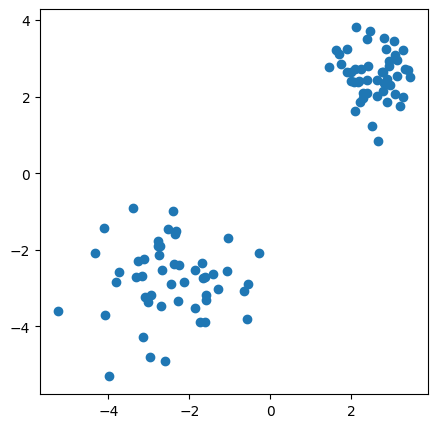

2×100 Array{Float32,2}:
 3.13092  2.93687  3.04991  3.08808  2.00028  …  -3.02163  -2.3672   -2.60112
 2.54954  2.79726  3.46605  2.07672  2.64679     -3.35002  -1.59008  -4.90216

In [2]:
X = randn(Float32, 2, 100)
X[:,1:50] .*= 0.5
X[:,1:50] .+= 5.0
X .-= 2.5

plt.figure(figsize=(5, 5))
plt.scatter(X[1,:], X[2,:])

X = X |> gpu

## Create a normalising flow by stacking multiple affine coupling layers

$$ f = f_1 \circ f_2 \circ \cdots \circ f_{N-1} \circ f_N : \mathcal{Z} \rightarrow \mathcal{X}$$

In [3]:
function stack_affinecouplings(xdim, ntrans; nhiddens=1, hdim=xdim, actfunc=relu)
    ts = []
    mask = instantiate(AlternatingMasking(xdim)) |> gpu
    for _ in 1:ntrans
        f1 = Dense(xdim, hdim, actfunc) |> gpu
        f21 = Dense(hdim, xdim) |> gpu
        f22 = Dense(hdim, xdim) |> gpu
        t = AffineCoupling(Chain(f1, f21), Chain(f1, f22), mask)
        push!(ts, t)
        mask = 1 .- mask
    end
    return compose(ts...)
end

NLAYERS = 4
H = 20
t = stack_affinecouplings(size(X, 1), NLAYERS; hdim=H)

opt = ADAM(2e-3)
ps = params(t)
;

## Define loss

$$\mathcal{L} = -\log p_{\mathcal{X}}(X) = -\log p_{\mathcal{Z}}(f^{-1}(X)) + \log \left| \det \frac{\partial f^{-1}(X)}{\partial X} \right|$$

We assume base distribution is the unit Gaussian, i.e. $p_{\mathcal{Z}} = \mathcal{N}(0,1)$.

In [4]:
const LOG2PI32 = log(2Float32(pi))

# The constant above and the overloadding below is a hack to make things work on GPU.
# TODO: figure out a better way to resolve GPU comptibility
function MLT.logpdf(dn::MLT.BatchNormal, x)
    diff = x .- dn.μ
    return -(LOG2PI32 .+ log.(dn.Σ) .+ (diff .* diff) ./ dn.Σ) ./ 2
end

function compute_loss(x)
    it = inv(t)
    z, logdet = it(x)
    # The hack below, again, is to make code GPU compatible
    logdensity = sum(MLT.logpdf(MLT.BatchNormal([0.0f0] |> gpu, [1.0f0] |> gpu), z), dims=1) + logdet
    return -sum(logdensity) / size(x, 2)
end

compute_loss (generic function with 1 method)

## Run optimisation

In [5]:
niters = 2_000

for iter = 1:niters
    print("."); if iter % 100 == 0 println("($iter/$niters) done") end
    loss = compute_loss(X)
    gs = Tracker.gradient(() -> loss, ps)
    update!(opt, ps, gs)
end

....................................................................................................(100/2000) done
....................................................................................................(200/2000) done
....................................................................................................(300/2000) done
....................................................................................................(400/2000) done
....................................................................................................(500/2000) done
....................................................................................................(600/2000) done
....................................................................................................(700/2000) done
....................................................................................................(800/2000) done
........................................................................

## Draw samples

$$ z \sim \mathcal{N}(0,1) $$
$$ x = f(z) $$

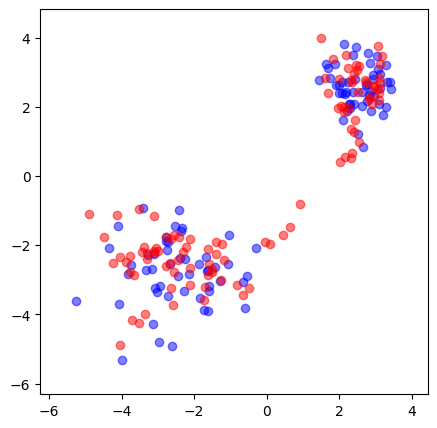

(-6.307387351989746, 4.821525573730469)

In [6]:
z = randn(2, 100) |> gpu
Xgen = t(z).rv |> cpu |> Flux.data

plt.figure(figsize=(5,5))
plt.scatter(X[1,:], X[2,:], c="blue", alpha=0.5, label="data")
plt.scatter(Xgen[1,:], Xgen[2,:], c="red", alpha=0.5, label="samples")
plt.xlim([extrema(X[1,:])...] + [-1, 1])
plt.ylim([extrema(X[2,:])...] + [-1, 1])